In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

In [ ]:
gold = pd.read_csv('gold_price_data.csv')
gold['Date'] = pd.to_datetime(gold['Date'], errors='coerce')
gold.head(5)

,Date,Value
0,1970-01-01,35.2
1,1970-04-01,35.1
2,1970-07-01,35.4
3,1970-10-01,36.2
4,1971-01-01,37.4


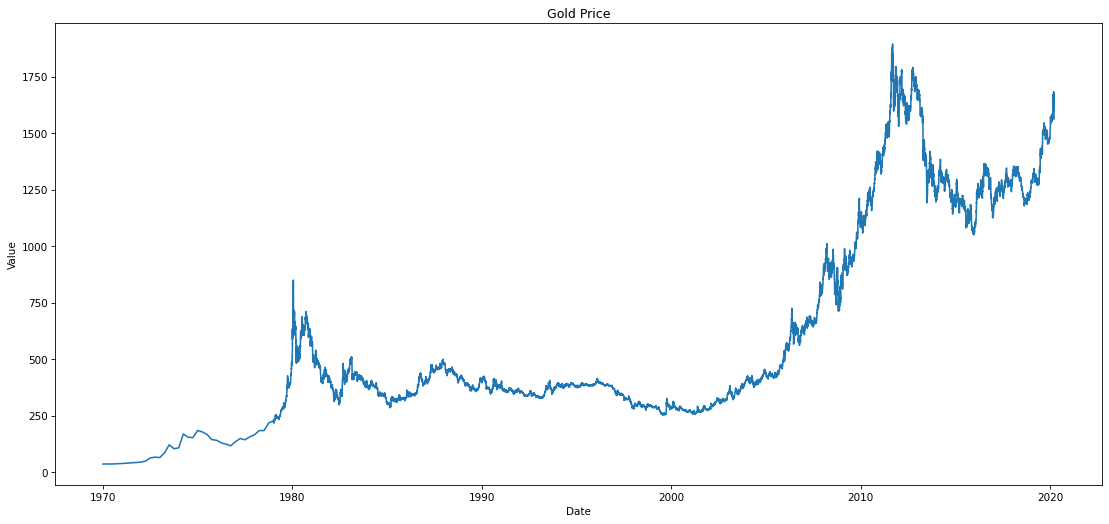

In [ ]:
plt.figure(figsize=(18, 8))
sns.lineplot(data=gold, x="Date", y="Value")
plt.title('Gold Price')
plt.show()

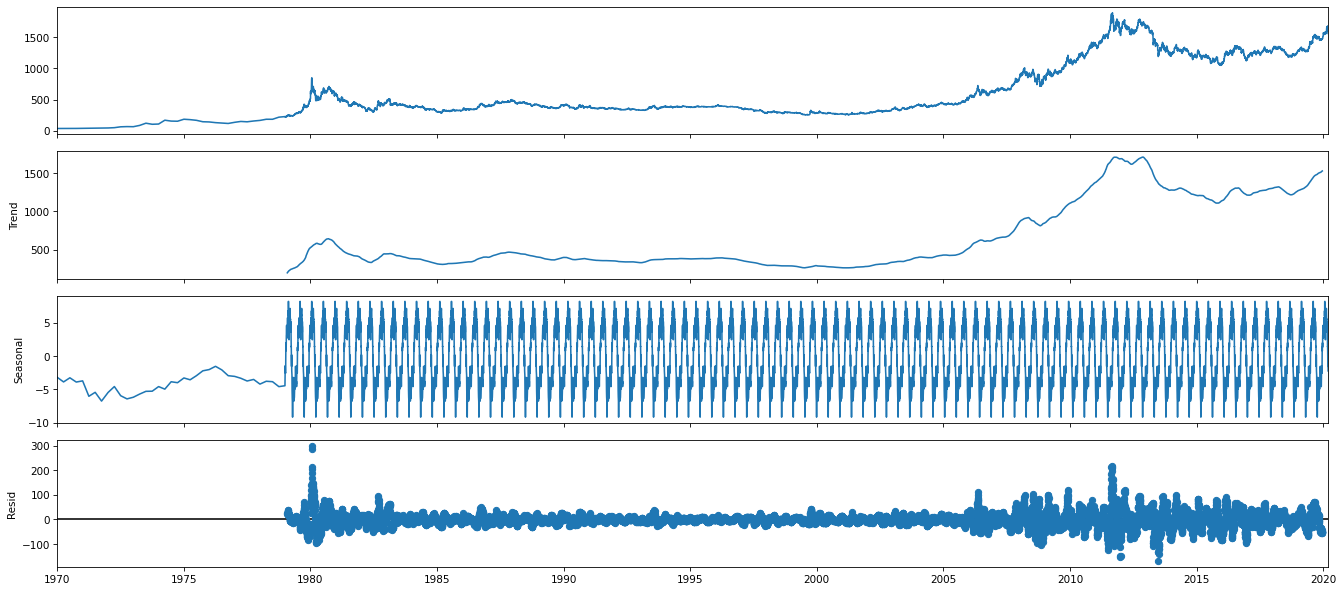

In [ ]:
gold_eda = gold.copy()
gold_eda.set_index('Date', inplace=True)
plt.rcParams.update({'figure.figsize': (18, 8), 'figure.dpi': 75})
result = seasonal_decompose(gold_eda, model='additive', period=120)
result.plot()
plt.show()

In [ ]:
X_train = gold[:8090]
X_test = gold[8090:]

In [ ]:
pvalue = 0.05
def define_d(data):
    X_train = adfuller(data, autolag='AIC')
    pvalue = X_train[1]
    if pvalue < 0.05:
        print("** Data Is Stationary **")
    else:
        print("** Indicating It Is Non-Stationary **")

define_d(X_train['Value'])
data_diff = X_train['Value'].diff()
data_diff.dropna(inplace=True)
define_d(data_diff)


** Indicating It Is Non-Stationary **
** Data Is Stationary **


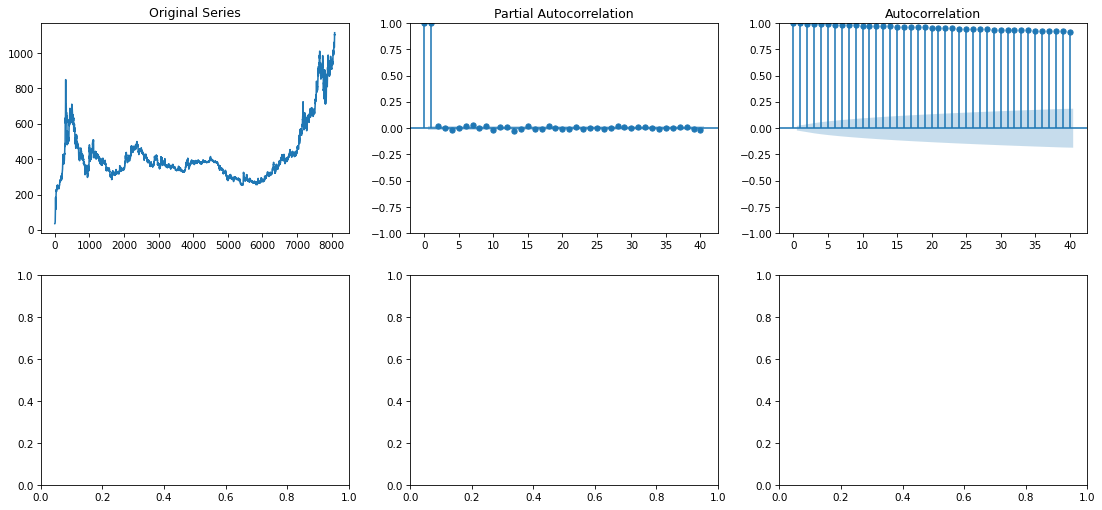

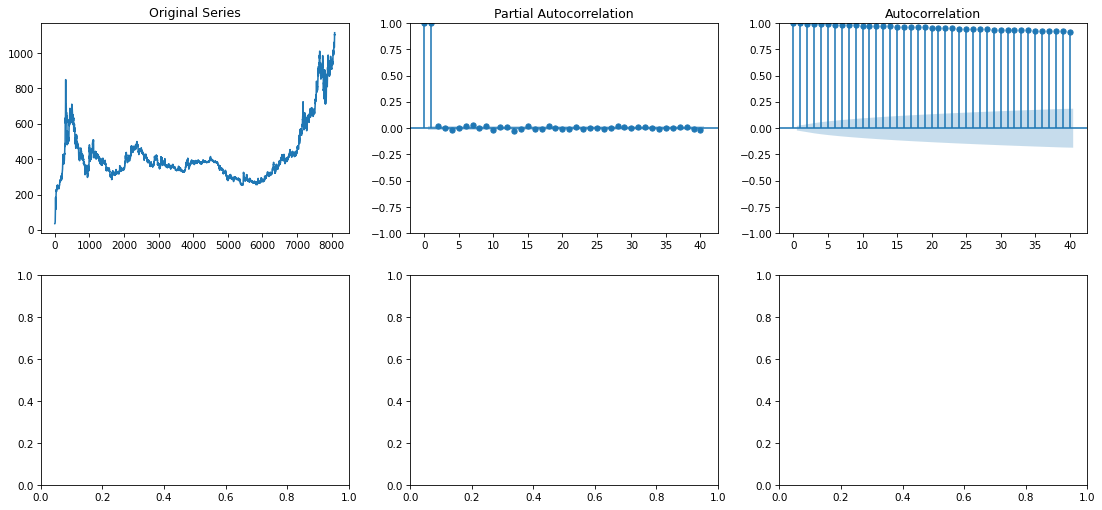

In [ ]:
plt.rcParams.update({'figure.figsize': (18, 8), 'figure.dpi': 75})
fig, axes = plt.subplots(2, 3)
axes[0, 0].plot(X_train['Value']); axes[0, 0].set_title('Original Series')
plot_pacf(X_train['Value'], ax=axes[0, 1])
plot_acf(X_train['Value'], ax=axes[0, 2])

In [ ]:
axes[1, 0].plot(data_diff); axes[1, 0].set_title('1st Order Differencing')
plot_pacf(data_diff, ax=axes[1, 1])
plot_acf(data_diff, ax=axes[1, 2])
plt.show()

In [ ]:
model_gold = ARIMA(X_train['Value'], order=(0, 1, 1))
gold_011 = model_gold.fit()
print(gold_011.summary())

                               SARIMAX Results                                
Dep. Variable:                  Value   No. Observations:                 8090
Model:                 ARIMA(0, 1, 1)   Log Likelihood              -26953.121
Date:                Mon, 13 Nov 2023   AIC                          53910.242
Time:                        18:34:18   BIC                          53924.239
Sample:                             0   HQIC                         53915.031
                               - 8090                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1         -0.0272      0.004     -7.172      0.000      -0.035      -0.020
sigma2        45.9130      0.182    252.695      0.000      45.557      46.269
Ljung-Box (L1) (Q):                   0.00   Jarque-

In [ ]:
forecast_result = gold_011.get_forecast(steps=2697)
fc = forecast_result.predicted_mean
conf = forecast_result.conf_int(alpha=0.05)

In [ ]:
def forecast_accuracy(forecast, actual):
    mape = (np.mean(np.abs(forecast - actual) / np.abs(actual)) * 100).round(2)
    rmse = np.sqrt(((forecast - actual) ** 2).mean())
    return {'Mean Absolute Percentage Error (%)': mape, 'Root Mean Squared Error': rmse}

In [ ]:
forecast_accuracy(fc, X_test['Value'].values)

{'Mean Absolute Percentage Error (%)': 16.17,
 'Root Mean Squared Error': 295.540128001788}

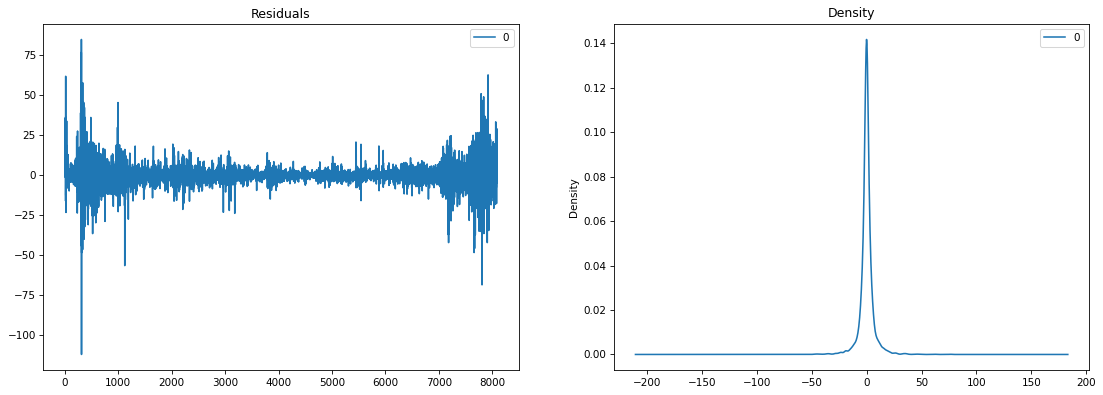

In [ ]:
plt.rcParams.update({'figure.figsize': (18, 6), 'figure.dpi': 75})
fig, ax = plt.subplots(1, 2)
residuals = pd.DataFrame(gold_011.resid)
residuals.plot(title="Residuals", ax=ax[0])
residuals.plot(kind='kde', title='Density', ax=ax[1])
plt.show()

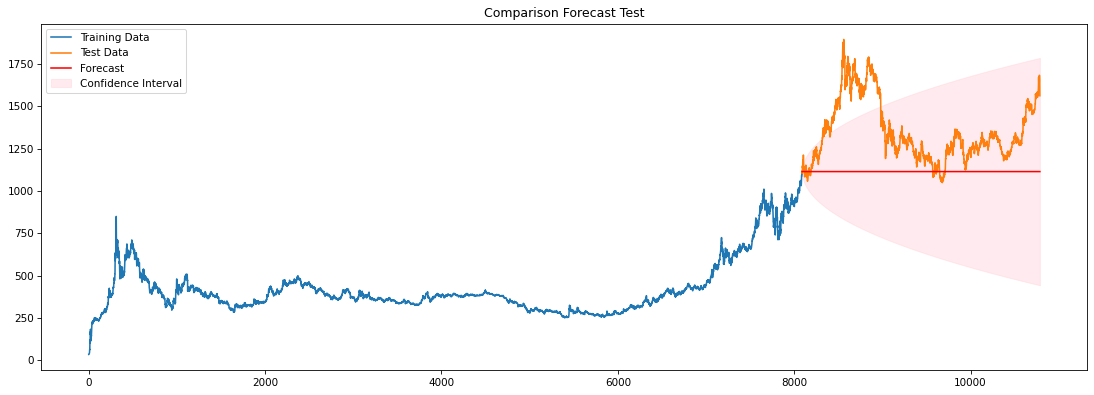

In [ ]:
forecast_result = gold_011.get_forecast(steps=2697)
forecast_mean = forecast_result.predicted_mean
confidence_interval = forecast_result.conf_int(alpha=0.05)

plt.figure(figsize=(18, 6))
plt.plot(X_train['Value'], label='Training Data')
plt.plot(X_test['Value'], label='Test Data')
plt.plot(forecast_mean.index, forecast_mean.values, color='red', label='Forecast')
plt.fill_between(confidence_interval.index, confidence_interval.iloc[:, 0], confidence_interval.iloc[:, 1], color='pink', alpha=0.3, label='Confidence Interval')
plt.title('Comparison Forecast Test')
plt.legend()
plt.show()

In [ ]:
gold_forecast_values = gold_011.forecast(9).values
gold_forecast_index = pd.date_range(X_test.index[-1], freq='MS', periods=9)

gold_forecast = pd.Series(gold_forecast_values, index=gold_forecast_index, name="Prediction")

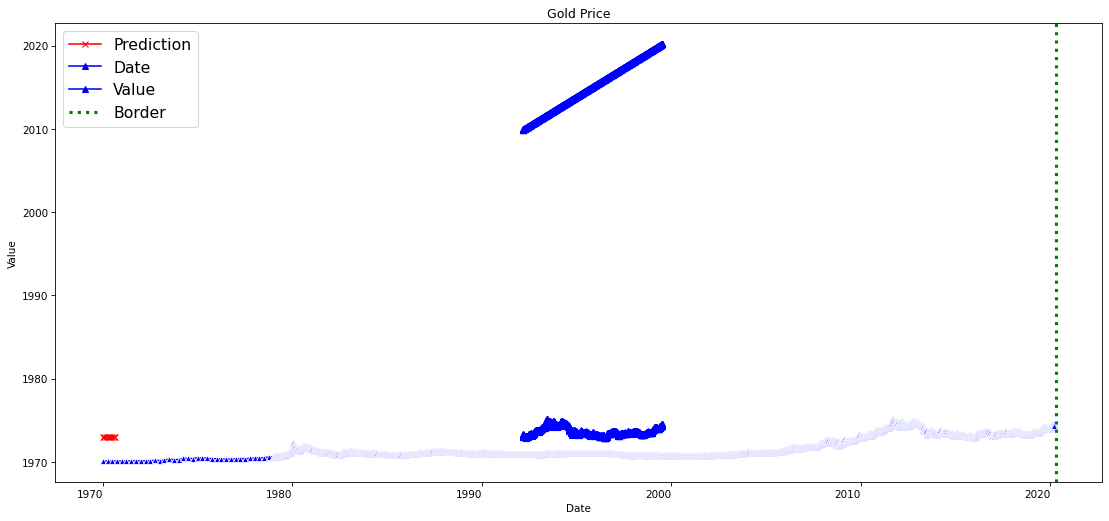

In [ ]:
fig, ax = plt.subplots(figsize=(18, 9))
sns.lineplot(x='Date', y='Value', data=gold, color='blue', marker='^')
gold_forecast.plot(ax=ax, c='red', marker='x', label='Prediction')
X_test.plot(ax=ax, c='blue', marker='^')
plt.title('Gold Price')
ax.axvline(x=18370, ls=':', linewidth=3, c='green', label='Border')
plt.legend(loc=0, fontsize=15)
plt.show()

In [ ]:
gold_fcast = gold_forecast.to_frame()
gold_fcast.rename_axis("Date", inplace=True)
gold_fcast.reset_index(inplace=True)
gold_fcast

,Date,Prediction
0,1970-01-01 00:00:00.000010786,1114.880117
1,1970-02-01 00:00:00.000010786,1114.880117
2,1970-03-01 00:00:00.000010786,1114.880117
3,1970-04-01 00:00:00.000010786,1114.880117
4,1970-05-01 00:00:00.000010786,1114.880117
5,1970-06-01 00:00:00.000010786,1114.880117
6,1970-07-01 00:00:00.000010786,1114.880117
7,1970-08-01 00:00:00.000010786,1114.880117
8,1970-09-01 00:00:00.000010786,1114.880117
